**DL and contextual word embeddings**

These codes are main adopted from https://github.com/bentrevett/pytorch-sentiment-analysis

In [ ]:
import torch
import numpy as np
import random
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):

        #text = [sent len, batch size]

        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]

        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors

        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        #hidden = [batch size, hid dim * num directions]

        return self.fc(hidden)


In [ ]:
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim,
                                              out_channels = n_filters,
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.permute(0, 2, 1)

        #embedded = [batch size, emb dim, sent len]

        conved = [F.relu(conv(embedded)) for conv in self.convs]

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

In [ ]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()

        # Initialize layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx=pad_idx)

        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                          dropout=dropout,
                          bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """Forward propagate through the neural network model.

        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.

        """
        #text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))
        #embedded = [sent len, batch size, emb dim]
        ## Output: (batch_size, seq_length, embedding_dim)

        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, hidden = self.gru(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors

        #hidden = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        #hidden = [batch size, hid dim * num directions]

        return self.fc(hidden)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion, include_lengths):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        if include_lengths:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)

        else:
            predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, include_lengths):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            if include_lengths:
                text, text_lengths = batch.text
                predictions = model(text, text_lengths).squeeze(1)

            else:
                predictions = model(batch.text).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def predict(model, iterator, include_lengths):
    y_predict=[]
    y_predict_prob=[]
    y_test=[]

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            if include_lengths:
                text, text_lengths = batch.text
                predictions = model(text, text_lengths).squeeze(1)

            else:
                predictions = model(batch.text).squeeze(1)

            pred_prob=torch.sigmoid(predictions)
            rounded_preds = torch.round(pred_prob)
            y_predict += rounded_preds.tolist()
            y_predict_prob += pred_prob.tolist()
            y_test += batch.label.tolist()
    return np.asarray(y_predict), np.asarray(y_predict_prob), np.asarray(y_test)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from sklearn.metrics import matthews_corrcoef,accuracy_score,f1_score,precision_score,recall_score
def get_evaluation_metrics(y_true,y_pred):
    metrics_dict=dict()
    metrics_dict['accuracy']=accuracy_score(y_true,y_pred)
    metrics_dict['precision']=precision_score(y_true,y_pred)
    metrics_dict['recall']=recall_score(y_true,y_pred)
    metrics_dict['f1']=f1_score(y_true,y_pred)
    metrics_dict['matthews_corr']=matthews_corrcoef(y_true,y_pred)
    return metrics_dict

In [ ]:
evaluation_dict=dict()

**BiLSTM & BiGRU**

In [ ]:
from torchtext.legacy import data
import os
current_p=os.getcwd()
file_p=os.path.join(current_p,'Reddit Data')

In [ ]:
from torchtext.legacy import data
TEXT = data.Field(sequential=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, use_vocab=False,preprocessing=int)

fields={'Label_encode':('label',LABEL),'Tokens':('text',TEXT)}

In [ ]:
import os
current_p=os.getcwd()
file_p=os.path.join(current_p,'Reddit Data')
train_data,valid_data,test_data=data.TabularDataset.splits(
    path=file_p,
    train='train.json',
    validation='valid.json',
    test='test.json',
    format='json',
    fields=fields
)

In [ ]:
print(vars(test_data.examples[30]))

{'label': 1, 'text': ['thank', 'wsb', 'member', 'rememb', 'hold', 'die', 'ride', 'dawn', 'happi', 'trade', 'slv', 'gme', 'amc', 'nok']}


In [ ]:
print(vars(train_data.examples[30]))

{'label': 1, 'text': ['hold', 'line', 'rocket', 'gem_ston', 'rocket', 'gem_ston', 'rocket', 'gem_ston', 'rocket']}


In [ ]:
print(vars(valid_data.examples[30]))

{'label': 0, 'text': ['fella', "y'all", 'come', 'back', 'get', 'gme']}


In [ ]:
import torchtext.vocab as vocab

w2v_embeddings = vocab.Vectors(name = 'Reddit Data/Word2Vec/GoogleNews_w2vec.txt',
                               cache = 'Reddit Data/Word2Vec',
                               unk_init = torch.Tensor.normal_)

In [ ]:
TEXT.build_vocab(train_data,vectors=w2v_embeddings)
LABEL.build_vocab(train_data)

In [ ]:
TEXT.pad_token

'<pad>'

In [ ]:
TEXT.vocab.vectors[TEXT.vocab.stoi['<pad>']]

tensor([ 0.1032, -1.6268,  0.5729, -0.6995, -0.8748,  2.2994, -1.4453, -0.7350,
        -1.3636,  0.3067, -1.0327,  1.3824,  1.1538, -0.5540, -0.8932, -0.3465,
         1.0827, -1.0121, -0.2642,  0.2560, -0.6692, -2.3203,  0.5021, -0.1246,
        -0.6560, -0.7049, -1.1843, -0.2645, -2.7675,  1.4802,  0.2942,  1.3924,
        -0.4910, -0.9858, -0.5375, -1.7054, -1.2253, -0.6665, -0.5090, -0.5193,
         0.4593, -0.6748, -0.1634, -0.7026,  0.5690,  0.4715,  0.4616, -1.3822,
         0.6241,  0.9364,  0.7707, -0.1255, -0.0446, -0.2705,  1.1501,  1.4566,
        -0.0417,  0.7463,  0.3322, -0.1859, -1.4301, -1.4317,  2.1155, -1.1853,
        -0.3650,  0.4927, -0.5866,  0.7948, -0.5345,  2.2011, -1.2147, -0.8642,
        -0.0450,  1.3279, -0.6276, -0.3739, -2.0552,  0.7384,  0.9454, -1.3522,
        -0.3972,  0.4209,  0.1005, -0.6588, -1.3583, -0.1869, -1.3208,  1.4487,
        -0.9434, -0.8170,  0.3422, -1.0809, -0.4060,  0.2415,  0.2559, -0.0605,
        -0.8933, -0.2504,  0.2037, -0.64

In [ ]:
TEXT.vocab.vectors.shape

torch.Size([35807, 300])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

BiLSTM

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 10
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,078,037 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([35807, 300])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ..., -1.4447,  0.8402, -0.8668],
        [ 0.1032, -1.6268,  0.5729,  ...,  0.3180, -0.1626, -0.0417],
        [-0.0320,  0.2715, -0.2891,  ...,  0.1562, -0.3906, -0.1592],
        ...,
        [ 1.2594,  0.5802, -0.6321,  ..., -0.3219, -0.9991,  0.6622],
        [ 0.8923,  1.2147,  0.5376,  ...,  0.2644,  0.3166, -1.5350],
        [ 0.1721, -1.1185,  0.2176,  ...,  0.1322,  0.4259, -1.0902]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0320,  0.2715, -0.2891,  ...,  0.1562, -0.3906, -0.1592],
        ...,
        [ 1.2594,  0.5802, -0.6321,  ..., -0.3219, -0.9991,  0.6622],
        [ 0.8923,  1.2147,  0.5376,  ...,  0.2644,  0.3166, -1.5350],
        [ 0.1721, -1.1185,  0.2176,  ...,  0.1322,  0.4259, -1.0902]])


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,078,037 trainable parameters


In [ ]:
#Train model
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS=True

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion,INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/w2vec_BiLSTMmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 0.691 | Train Acc: 52.96%
	 Val. Loss: 0.693 |  Val. Acc: 69.25%
Epoch: 02 | Epoch Time: 1m 25s
	Train Loss: 0.685 | Train Acc: 54.03%
	 Val. Loss: 0.631 |  Val. Acc: 63.09%
Epoch: 03 | Epoch Time: 1m 27s
	Train Loss: 0.592 | Train Acc: 69.32%
	 Val. Loss: 0.593 |  Val. Acc: 59.29%
Epoch: 04 | Epoch Time: 1m 26s
	Train Loss: 0.533 | Train Acc: 73.95%
	 Val. Loss: 0.512 |  Val. Acc: 51.19%
Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.490 | Train Acc: 76.76%
	 Val. Loss: 0.501 |  Val. Acc: 50.13%
Epoch: 06 | Epoch Time: 1m 25s
	Train Loss: 0.465 | Train Acc: 78.24%
	 Val. Loss: 0.502 |  Val. Acc: 50.17%
Epoch: 07 | Epoch Time: 1m 25s
	Train Loss: 0.445 | Train Acc: 79.38%
	 Val. Loss: 0.495 |  Val. Acc: 49.55%
Epoch: 08 | Epoch Time: 1m 26s
	Train Loss: 0.427 | Train Acc: 80.45%
	 Val. Loss: 0.503 |  Val. Acc: 50.33%
Epoch: 09 | Epoch Time: 1m 23s
	Train Loss: 0.411 | Train Acc: 81.40%
	 Val. Loss: 0.514 |  Val. Acc: 51.35%
Epoch: 10 | Epoch T

In [ ]:
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)
metrics=get_evaluation_metrics(y_true,y_pred)
print(metrics)

{'accuracy': 0.7557779947916666, 'precision': 0.7584140969162996, 'recall': 0.7253117627232896, 'f1': 0.741493668705315, 'matthews_corr': 0.5107346385905418}


In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/w2vec_BiLSTMmodel.pt'))
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)

metrics=get_evaluation_metrics(y_true,y_pred)
evaluation_dict['word2vec+BiLSTM']=[metrics,y_pred,y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7661946614583334, 'precision': 0.7768131669379634, 'recall': 0.7237950792045837, 'f1': 0.7493675303149262, 'matthews_corr': 0.5319489220021474}


In [ ]:
evaluation_dict

{'word2vec+BiLSTM': [{'accuracy': 0.7661946614583334,
   'precision': 0.7768131669379634,
   'recall': 0.7237950792045837,
   'f1': 0.7493675303149262,
   'matthews_corr': 0.5319489220021474},
  array([0., 0., 1., ..., 1., 1., 1.]),
  array([0.25730208, 0.3950069 , 0.528404  , ..., 0.89427865, 0.97807616,
         0.94837987]),
  array([0., 0., 0., ..., 1., 1., 1.])]}

BiGRU

In [ ]:
TEXT = data.Field(sequential=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, use_vocab=False,preprocessing=int)

fields={'Label_encode':('label',LABEL),'Tokens':('text',TEXT)}

In [ ]:
train_data,valid_data,test_data=data.TabularDataset.splits(
    path=file_p,
    train='train.json',
    validation='valid.json',
    test='test.json',
    format='json',
    fields=fields
)

In [ ]:
w2v_embeddings = vocab.Vectors(name = 'Reddit Data/Word2Vec/GoogleNews_w2vec.txt',
                               cache = 'Reddit Data/Word2Vec',
                               unk_init = torch.Tensor.normal_)

In [ ]:
TEXT.build_vocab(train_data, vectors=w2v_embeddings)
LABEL.build_vocab(train_data)

In [ ]:
TEXT.pad_token

'<pad>'

In [ ]:
TEXT.vocab.vectors[TEXT.vocab.stoi['<pad>']]

tensor([ 0.2830, -0.0118,  2.8122,  0.0139, -2.1980,  0.4822,  0.5802,  0.4480,
         2.1580, -0.7408, -0.5547,  0.4285, -1.4326,  1.8095,  0.6048, -0.0434,
        -0.8797, -0.0246,  2.5886, -0.7145,  1.6420,  0.3631, -0.2524,  0.6571,
         0.7801,  0.4597, -2.1794, -0.9077, -1.2133,  0.6321, -1.6600,  1.1422,
        -0.0645, -0.6532,  0.3675, -0.3731, -0.7669, -0.9682,  0.3727,  1.4716,
         0.5704, -0.4303, -1.5339,  0.7233, -0.7759,  1.7938,  1.2074, -1.2815,
         0.6802, -0.0553,  0.8862, -0.3312,  0.4211,  0.7117, -0.6974,  1.5942,
         1.1334,  0.3630,  0.9284,  0.2573, -0.2855,  1.0653, -0.4345,  0.7062,
         0.7869,  0.4423,  0.1055, -0.9142,  1.0618,  1.7697, -0.4495, -0.7490,
        -1.2562,  0.6927,  0.8468,  0.3769, -2.1307,  1.9362, -0.5090,  0.4294,
        -0.3738,  0.1951,  0.9953,  1.1275, -2.8874, -0.8086, -0.5714,  0.5279,
        -0.8257,  0.6465,  2.2281,  0.6334, -0.0557,  0.3232,  0.8646, -1.2108,
        -1.5809, -1.5757, -0.3230, -0.34

In [ ]:
TEXT.vocab.vectors.shape

torch.Size([35807, 300])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
model = BiGRU(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,244,181 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([35807, 300])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.3386,  1.0568,  1.0754,  ...,  0.8396, -0.6316, -1.5424],
        [ 0.2830, -0.0118,  2.8122,  ..., -1.4852, -0.8070, -0.5910],
        [-0.0320,  0.2715, -0.2891,  ...,  0.1562, -0.3906, -0.1592],
        ...,
        [ 0.4066,  1.0539,  0.1286,  ..., -0.7367,  0.0761, -1.6207],
        [ 0.7743,  2.2916, -0.9739,  ..., -0.2869,  2.4793,  0.4265],
        [ 1.2922,  0.4906, -1.7092,  ..., -0.8636, -0.6713,  1.0700]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0320,  0.2715, -0.2891,  ...,  0.1562, -0.3906, -0.1592],
        ...,
        [ 0.4066,  1.0539,  0.1286,  ..., -0.7367,  0.0761, -1.6207],
        [ 0.7743,  2.2916, -0.9739,  ..., -0.2869,  2.4793,  0.4265],
        [ 1.2922,  0.4906, -1.7092,  ..., -0.8636, -0.6713,  1.0700]])


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS=True

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion,INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/w2vec_BiGRUmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 15s
	Train Loss: 0.668 | Train Acc: 60.07%
	 Val. Loss: 0.652 |  Val. Acc: 65.15%
Epoch: 02 | Epoch Time: 1m 14s
	Train Loss: 0.610 | Train Acc: 67.96%
	 Val. Loss: 0.551 |  Val. Acc: 55.12%
Epoch: 03 | Epoch Time: 1m 14s
	Train Loss: 0.530 | Train Acc: 74.26%
	 Val. Loss: 0.507 |  Val. Acc: 50.70%
Epoch: 04 | Epoch Time: 1m 18s
	Train Loss: 0.487 | Train Acc: 77.14%
	 Val. Loss: 0.492 |  Val. Acc: 49.16%
Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 0.463 | Train Acc: 78.15%
	 Val. Loss: 0.498 |  Val. Acc: 49.78%
Epoch: 06 | Epoch Time: 1m 17s
	Train Loss: 0.443 | Train Acc: 79.36%
	 Val. Loss: 0.494 |  Val. Acc: 49.36%
Epoch: 07 | Epoch Time: 1m 17s
	Train Loss: 0.426 | Train Acc: 80.34%
	 Val. Loss: 0.488 |  Val. Acc: 48.77%
Epoch: 08 | Epoch Time: 1m 17s
	Train Loss: 0.410 | Train Acc: 81.18%
	 Val. Loss: 0.489 |  Val. Acc: 48.92%
Epoch: 09 | Epoch Time: 1m 16s
	Train Loss: 0.398 | Train Acc: 81.84%
	 Val. Loss: 0.489 |  Val. Acc: 48.93%
Epoch: 10 | Epoch T

In [ ]:
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)
metrics=get_evaluation_metrics(y_true,y_pred)
print(metrics)

{'accuracy': 0.7576497395833334, 'precision': 0.7958366693354684, 'recall': 0.6700370744860128, 'f1': 0.7275388838060384, 'matthews_corr': 0.5183392215429762}


In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/w2vec_BiGRUmodel.pt'))
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)

metrics=get_evaluation_metrics(y_true,y_pred)
evaluation_dict['word2vec+BiGRU']=[metrics,y_pred,y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7679036458333334, 'precision': 0.7926319787314849, 'recall': 0.7034041118975396, 'f1': 0.7453571428571428, 'matthews_corr': 0.5367420831252269}


In [ ]:
evaluation_dict

{'word2vec+BiLSTM': [{'accuracy': 0.765869140625,
   'precision': 0.7913093196112064,
   'recall': 0.6996966632962589,
   'f1': 0.7426884894016635,
   'matthews_corr': 0.5327646215251076},
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 'word2vec+BiGRU': [{'accuracy': 0.7639973958333334,
   'precision': 0.7643778319972115,
   'recall': 0.7391304347826086,
   'f1': 0.751542152159013,
   'matthews_corr': 0.5271958407746923},
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])]}

**CNN**

In [ ]:
TEXT = data.Field(sequential=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)

fields = {'Label_encode': ('label', LABEL), 'Tokens': ('text', TEXT)}

In [ ]:
current_p = os.getcwd()
file_p = os.path.join(current_p, 'Reddit Data')
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p,
    train='train_lstem3.json',
    validation='valid_lstem3.json',
    test='test_lstem3.json',
    format='json',
    fields=fields
)


In [ ]:
w2v_embeddings = vocab.Vectors(name = 'Reddit Data/Word2Vec/GoogleNews_w2vec.txt',
                               cache = 'Reddit Data/Word2Vec',
                               unk_init = torch.Tensor.normal_)

In [ ]:
TEXT.build_vocab(train_data, vectors=w2v_embeddings)
LABEL.build_vocab(train_data)

In [ ]:
TEXT.vocab.vectors.shape

torch.Size([48637, 300])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [2,3]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN1d(INPUT_DIM,
              EMBEDDING_DIM,
              N_FILTERS,
              FILTER_SIZES,
              OUTPUT_DIM,
              DROPOUT,
              PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,741,501 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.3842, -0.1838, -0.6351,  ...,  0.4819,  1.3383, -0.0965],
        [-0.2722,  1.0216, -0.9359,  ..., -0.0260,  0.6247, -0.3309],
        [-0.5881,  0.9026,  1.0273,  ..., -0.4808, -1.5580,  1.7417],
        ...,
        [-1.1197,  0.2241, -0.2745,  ..., -0.6440,  0.8730, -0.9475],
        [ 0.7263,  0.8048, -1.1821,  ..., -2.0554,  0.5140,  1.0250],
        [-0.4894, -0.5980, -0.4186,  ...,  1.1885,  0.4575,  0.0318]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5881,  0.9026,  1.0273,  ..., -0.4808, -1.5580,  1.7417],
        ...,
        [-1.1197,  0.2241, -0.2745,  ..., -0.6440,  0.8730, -0.9475],
        [ 0.7263,  0.8048, -1.1821,  ..., -2.0554,  0.5140,  1.0250],
        [-0.4894, -0.5980, -0.4186,  ...,  1.1885,  0.4575,  0.0318]])


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS=False

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion,INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/w2vec_CNNmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.561 | Train Acc: 70.30%
	 Val. Loss: 0.511 |  Val. Acc: 51.09%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.479 | Train Acc: 76.79%
	 Val. Loss: 0.546 |  Val. Acc: 54.60%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.425 | Train Acc: 80.37%
	 Val. Loss: 0.525 |  Val. Acc: 52.52%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.378 | Train Acc: 83.16%
	 Val. Loss: 0.516 |  Val. Acc: 51.59%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.333 | Train Acc: 85.44%
	 Val. Loss: 0.555 |  Val. Acc: 55.47%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.294 | Train Acc: 87.35%
	 Val. Loss: 0.609 |  Val. Acc: 60.85%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.259 | Train Acc: 89.01%
	 Val. Loss: 0.677 |  Val. Acc: 67.68%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.229 | Train Acc: 90.45%
	 Val. Loss: 0.717 |  Val. Acc: 71.65%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.205 | Train Acc: 91.48%
	 Val. Loss: 0.800 |  Val. Acc: 79.98%
Epoch: 10 | Epoch T

In [ ]:
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)

metrics=get_evaluation_metrics(y_true,y_pred)
print(metrics)

{'accuracy': 0.7331307534185361, 'precision': 0.744378698224852, 'recall': 0.6907027818448024, 'f1': 0.7165369280425288, 'matthews_corr': 0.466254507491087}


In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/w2vec_CNNmodel.pt'))
y_pred,y_pred_prob,y_true = predict(model,test_iterator,INCLUDE_LENGTHS)

metrics=get_evaluation_metrics(y_true,y_pred)
evaluation_dict['word2vec+CNN']=[metrics,y_pred,y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7484136205201537, 'precision': 0.7769182521430065, 'recall': 0.6800878477306003, 'f1': 0.7252854493998243, 'matthews_corr': 0.4988539116119869}


In [ ]:
evaluation_dict

{'word2vec+BiLSTM': [{'accuracy': 0.765869140625,
   'precision': 0.7913093196112064,
   'recall': 0.6996966632962589,
   'f1': 0.7426884894016635,
   'matthews_corr': 0.5327646215251076},
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 'word2vec+BiGRU': [{'accuracy': 0.7639973958333334,
   'precision': 0.7643778319972115,
   'recall': 0.7391304347826086,
   'f1': 0.751542152159013,
   'matthews_corr': 0.5271958407746923},
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 'word2vec+CNN': [{'accuracy': 0.7527035481276253,
   'precision': 0.7335873895721462,
   'recall': 0.7750732064421669,
   'f1': 0.7537599003292694,
   'matthews_corr': 0.506547021492231},
  array([1., 0., 0., ..., 1., 1., 1.]),
  array([1., 0., 0., ..., 0., 1., 1.])]}

**GLOVE + DL**

In [ ]:
glove_vec = vocab.Vectors(name='Reddit Data/glove/glove.twitter.27B.100d.txt',
                          cache='Reddit Data/glove',
                          unk_init=torch.Tensor.normal_)

BiLSTM & BiGRU

In [ ]:
TEXT = data.Field(sequential=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)

fields = {'Label_encode': ('label', LABEL), 'Tokens': ('text', TEXT)}

file_p = os.path.join(current_p, 'Reddit Data')
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p,
    train='train.json',
    validation='valid.json',
    test='test.json',
    format='json',
    fields=fields
)

In [ ]:
TEXT.build_vocab(train_data,vectors=glove_vec)
LABEL.build_vocab(train_data)

In [ ]:
TEXT.vocab.vectors.shape

torch.Size([35807, 100])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
#BiLSTM
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 10
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTM(INPUT_DIM,
               EMBEDDING_DIM,
               HIDDEN_DIM,
               OUTPUT_DIM,
               N_LAYERS,
               BIDIRECTIONAL,
               DROPOUT,
               PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,559,773 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([35807, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.6374, -0.0418, -1.4557,  ..., -0.0390,  0.1676,  2.6425],
        [-1.1838, -1.2965,  0.8211,  ..., -0.0688, -1.5944, -1.1358],
        [ 0.4274, -0.0909, -0.1783,  ...,  0.7011, -0.1588, -0.1800],
        ...,
        [-0.3403, -1.4027,  0.8282,  ..., -0.7417, -1.0885,  0.4222],
        [ 1.2101, -0.0990,  0.3096,  ...,  0.5585, -0.8345, -0.7272],
        [ 0.7422, -0.9827, -0.8505,  ...,  1.2911, -0.5511,  0.6086]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4274, -0.0909, -0.1783,  ...,  0.7011, -0.1588, -0.1800],
        ...,
        [-0.3403, -1.4027,  0.8282,  ..., -0.7417, -1.0885,  0.4222],
        [ 1.2101, -0.0990,  0.3096,  ...,  0.5585, -0.8345, -0.7272],
        [ 0.7422, -0.9827, -0.8505,  ...,  1.2911, -0.5511,  0.6086]])


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,559,773 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS = True

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/glove_BiLSTMmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.606 | Train Acc: 66.97%
	 Val. Loss: 0.520 |  Val. Acc: 52.04%
Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.518 | Train Acc: 74.60%
	 Val. Loss: 0.502 |  Val. Acc: 50.24%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 0.489 | Train Acc: 76.46%
	 Val. Loss: 0.493 |  Val. Acc: 49.35%
Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 0.469 | Train Acc: 77.69%
	 Val. Loss: 0.487 |  Val. Acc: 48.74%
Epoch: 05 | Epoch Time: 0m 59s
	Train Loss: 0.456 | Train Acc: 78.58%
	 Val. Loss: 0.494 |  Val. Acc: 49.40%
Epoch: 06 | Epoch Time: 1m 0s
	Train Loss: 0.443 | Train Acc: 79.45%
	 Val. Loss: 0.492 |  Val. Acc: 49.21%
Epoch: 07 | Epoch Time: 1m 0s
	Train Loss: 0.433 | Train Acc: 79.78%
	 Val. Loss: 0.485 |  Val. Acc: 48.54%
Epoch: 08 | Epoch Time: 0m 59s
	Train Loss: 0.420 | Train Acc: 80.56%
	 Val. Loss: 0.494 |  Val. Acc: 49.36%
Epoch: 09 | Epoch Time: 1m 0s
	Train Loss: 0.413 | Train Acc: 80.93%
	 Val. Loss: 0.520 |  Val. Acc: 52.01%
Epoch: 10 | Epoch Time

In [ ]:

y_pred, y_pred_prob, y_true = predict(model, test_iterator, INCLUDE_LENGTHS)
metrics = get_evaluation_metrics(y_true, y_pred)
metrics

{'accuracy': 0.767333984375,
 'precision': 0.7918011007781363,
 'recall': 0.703067071115605,
 'f1': 0.7448004998661072,
 'matthews_corr': 0.5355690618220835}

In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/glove_BiLSTMmodel.pt'))

y_pred, y_pred_prob, y_true = predict(model, test_iterator, INCLUDE_LENGTHS)

metrics = get_evaluation_metrics(y_true, y_pred)
evaluation_dict['glove+BiLSTM'] = [metrics, y_pred, y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7705078125, 'precision': 0.8068584942845881, 'recall': 0.689922480620155, 'f1': 0.7438226744186047, 'matthews_corr': 0.5436842412532721}


In [ ]:
glove_vec = vocab.Vectors(name='Reddit Data/glove/glove.twitter.27B.100d.txt',
                          cache='Reddit Data/glove',
                          unk_init=torch.Tensor.normal_)

In [ ]:

TEXT = data.Field(sequential=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)

fields = {'Label_encode': ('label', LABEL), 'Tokens': ('text', TEXT)}

file_p = os.path.join(current_p, 'Reddit Data')
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p,
    train='train.json',
    validation='valid.json',
    test='test.json',
    format='json',
    fields=fields
)


In [ ]:
TEXT.build_vocab(train_data, vectors=glove_vec)
LABEL.build_vocab(train_data)
TEXT.vocab.vectors.shape

torch.Size([35807, 100])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
#BiGRU
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 10
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiGRU(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,315,037 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([35807, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-2.0381,  0.7155, -0.4842,  ...,  0.0315, -0.9411,  0.0561],
        [-0.9160, -1.4147,  2.4218,  ..., -0.8534, -1.8712, -0.2209],
        [ 0.4274, -0.0909, -0.1783,  ...,  0.7011, -0.1588, -0.1800],
        ...,
        [ 0.4630, -0.7078, -1.4032,  ..., -0.1069, -1.0257,  0.1335],
        [-0.7088,  0.2905, -0.4676,  ...,  0.5253,  0.4376,  0.9916],
        [-1.9795,  0.3914, -1.9789,  ..., -1.0945, -0.8275, -0.2732]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4274, -0.0909, -0.1783,  ...,  0.7011, -0.1588, -0.1800],
        ...,
        [ 0.4630, -0.7078, -1.4032,  ..., -0.1069, -1.0257,  0.1335],
        [-0.7088,  0.2905, -0.4676,  ...,  0.5253,  0.4376,  0.9916],
        [-1.9795,  0.3914, -1.9789,  ..., -1.0945, -0.8275, -0.2732]])


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,315,037 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS = True

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/glove_BiGRUmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.578 | Train Acc: 69.56%
	 Val. Loss: 0.537 |  Val. Acc: 53.74%
Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 0.510 | Train Acc: 75.08%
	 Val. Loss: 0.489 |  Val. Acc: 48.86%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 0.487 | Train Acc: 76.48%
	 Val. Loss: 0.487 |  Val. Acc: 48.68%
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 0.466 | Train Acc: 77.87%
	 Val. Loss: 0.485 |  Val. Acc: 48.47%
Epoch: 05 | Epoch Time: 0m 59s
	Train Loss: 0.454 | Train Acc: 78.64%
	 Val. Loss: 0.490 |  Val. Acc: 49.00%
Epoch: 06 | Epoch Time: 0m 59s
	Train Loss: 0.442 | Train Acc: 79.21%
	 Val. Loss: 0.489 |  Val. Acc: 48.94%
Epoch: 07 | Epoch Time: 0m 58s
	Train Loss: 0.432 | Train Acc: 79.91%
	 Val. Loss: 0.483 |  Val. Acc: 48.33%
Epoch: 08 | Epoch Time: 0m 59s
	Train Loss: 0.423 | Train Acc: 80.36%
	 Val. Loss: 0.483 |  Val. Acc: 48.33%
Epoch: 09 | Epoch Time: 0m 59s
	Train Loss: 0.415 | Train Acc: 80.88%
	 Val. Loss: 0.493 |  Val. Acc: 49.32%
Epoch: 10 | Epoch T

In [ ]:
y_pred, y_pred_prob, y_true = predict(model, test_iterator, INCLUDE_LENGTHS)

metrics = get_evaluation_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.7701009114583334, 'precision': 0.7964905588403586, 'recall': 0.7037411526794742, 'f1': 0.7472488145298382, 'matthews_corr': 0.5413550219615594}


In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/glove_BiGRUmodel.pt'))

y_pred, y_pred_prob, y_true = predict(model, test_iterator, INCLUDE_LENGTHS)

metrics = get_evaluation_metrics(y_true, y_pred)
evaluation_dict['glove+BiGRU'] = [metrics, y_pred, y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7696940104166666, 'precision': 0.7714235746764603, 'recall': 0.7433434445567914, 'f1': 0.7571232406453828, 'matthews_corr': 0.5386283816006766}


In [ ]:
#CNN
TEXT = data.Field(sequential=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)

fields = {'Label_encode': ('label', LABEL), 'Tokens': ('text', TEXT)}

file_p = os.path.join(current_p, 'Reddit Data')
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p,
    train='train_lstem3.json',
    validation='valid_lstem3.json',
    test='test_lstem3.json',
    format='json',
    fields=fields
)

In [ ]:
glove_vec = vocab.Vectors(name='Reddit Data/glove/glove.twitter.27B.100d.txt',
                          cache='Reddit Data/glove',
                          unk_init=torch.Tensor.normal_)

In [ ]:
TEXT.build_vocab(train_data, vectors=glove_vec)
LABEL.build_vocab(train_data)

In [ ]:
TEXT.vocab.vectors.shape

torch.Size([48637, 100])

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 64
FILTER_SIZES = [2, 3]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN1d(INPUT_DIM,
              EMBEDDING_DIM,
              N_FILTERS,
              FILTER_SIZES,
              OUTPUT_DIM,
              DROPOUT,
              PAD_IDX)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,895,957 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.4290, -1.5285,  1.1035,  ..., -0.2543, -0.7078, -0.9456],
        [ 0.2207,  1.8187, -1.2881,  ..., -0.7617, -1.3683, -0.4202],
        [ 0.0310,  1.1567, -2.3635,  ...,  1.2009,  1.1024,  0.7224],
        ...,
        [-0.7321, -1.0117, -1.2753,  ..., -1.9088,  1.2597,  1.5051],
        [ 0.9803,  2.0135,  0.0842,  ...,  0.6145, -0.7652,  0.6233],
        [-0.7638,  0.5280, -0.6244,  ...,  2.4367,  0.4135, -0.7559]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0310,  1.1567, -2.3635,  ...,  1.2009,  1.1024,  0.7224],
        ...,
        [-0.7321, -1.0117, -1.2753,  ..., -1.9088,  1.2597,  1.5051],
        [ 0.9803,  2.0135,  0.0842,  ...,  0.6145, -0.7652,  0.6233],
        [-0.7638,  0.5280, -0.6244,  ...,  2.4367,  0.4135, -0.7559]])


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

INCLUDE_LENGTHS = False

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, INCLUDE_LENGTHS)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, INCLUDE_LENGTHS)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './Reddit Data/model/glove_CNNmodel.pt')
    #else:
        #break
    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_loss * 100:.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.582 | Train Acc: 67.82%
	 Val. Loss: 0.529 |  Val. Acc: 52.91%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.503 | Train Acc: 74.98%
	 Val. Loss: 0.518 |  Val. Acc: 51.77%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.456 | Train Acc: 78.37%
	 Val. Loss: 0.495 |  Val. Acc: 49.52%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.418 | Train Acc: 80.81%
	 Val. Loss: 0.504 |  Val. Acc: 50.42%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.386 | Train Acc: 82.61%
	 Val. Loss: 0.522 |  Val. Acc: 52.18%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.354 | Train Acc: 84.33%
	 Val. Loss: 0.531 |  Val. Acc: 53.09%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.329 | Train Acc: 85.65%
	 Val. Loss: 0.565 |  Val. Acc: 56.54%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.303 | Train Acc: 86.95%
	 Val. Loss: 0.567 |  Val. Acc: 56.71%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.280 | Train Acc: 87.96%
	 Val. Loss: 0.611 |  Val. Acc: 61.07%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/glove_CNNmodel.pt'))
y_pred, y_pred_prob, y_true = predict(model, test_iterator, INCLUDE_LENGTHS)


metrics = get_evaluation_metrics(y_true, y_pred)
evaluation_dict['glove+CNN'] = [metrics, y_pred, y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7591384395388328, 'precision': 0.7509516041326808, 'recall': 0.7582357247437774, 'f1': 0.7545760859666697, 'matthews_corr': 0.5181444321376383}


**Transformer**

In [ ]:
from transformers import RobertaTokenizer,AutoTokenizer,BartTokenizer,RobertaModel,AutoModel,BartModel

In [ ]:
class TransformerGRU(nn.Module):
    def __init__(self,mname,hidden_dim,output_dim,n_layers,bidirectional,dropout):

        super().__init__()

        if mname=='roberta':
            self.nlp=RobertaModel.from_pretrained('roberta-base')
        elif mname=='finbert':
            self.nlp=AutoModel.from_pretrained("ProsusAI/finbert")
        elif mname=='bart':
            self.nlp=BartModel.from_pretrained("facebook/bart-base")
        else:
            raise ValueError

        if mname=='bart':
            embedding_dim = self.nlp.config.to_dict()['d_model']

        else:
            embedding_dim = self.nlp.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=0 if n_layers < 2 else dropout)

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        with torch.no_grad():

            embedded = self.nlp(text)[0]

        #embedded = [batch size, sent len, emb dim]

        _, hidden = self.rnn(embedded)

        #hidden = [n layers * n directions, batch size, emb dim]

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])

        #hidden = [batch size, hid dim]

        output = self.out(hidden)

        #output = [batch size, out dim]

        return output


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

RoBerta

In [ ]:
#RoBert
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_input_length = tokenizer.max_model_input_sizes['roberta-base']
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

0 2 1 3


In [ ]:
TEXT = data.Field(batch_first=True,
                  use_vocab=False,
                  tokenize=tokenize_and_cut,
                  preprocessing=tokenizer.convert_tokens_to_ids,
                  init_token=init_token_idx,
                  eos_token=eos_token_idx,
                  pad_token=pad_token_idx,
                  unk_token=unk_token_idx)

LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)
fields = [("label", LABEL), ("text", TEXT)]
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p, train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv', skip_header=True, fields=fields)
print(vars(test_data.examples[30]))
LABEL.build_vocab(train_data)

{'label': 1, 'text': [31653, 885, 37844, 919, 46223, 428, 946, 1597, 3068, 14131, 48288, 118, 721, 3369, 705, 821, 1794, 524, 438, 295, 1638]}


In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = TransformerGRU('roberta',
                       HIDDEN_DIM,
                       OUTPUT_DIM,
                       N_LAYERS,
                       BIDIRECTIONAL,
                       DROPOUT)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 127,404,801 trainable parameters


In [ ]:
for name, param in model.named_parameters():
    if name.startswith('nlp'):
        param.requires_grad = False
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, False)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, False)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'./Reddit Data/model/roberta-model.pt')
    #else:
    #break #early stop

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')


Epoch: 01 | Epoch Time: 1m 13s
	Train Loss: 0.582 | Train Acc: 68.50%
	 Val. Loss: 0.533 |  Val. Acc: 72.53%
Epoch: 02 | Epoch Time: 1m 13s
	Train Loss: 0.539 | Train Acc: 72.07%
	 Val. Loss: 0.522 |  Val. Acc: 73.35%
Epoch: 03 | Epoch Time: 1m 13s
	Train Loss: 0.520 | Train Acc: 73.36%
	 Val. Loss: 0.509 |  Val. Acc: 73.90%
Epoch: 04 | Epoch Time: 1m 13s
	Train Loss: 0.506 | Train Acc: 74.43%
	 Val. Loss: 0.503 |  Val. Acc: 74.71%
Epoch: 05 | Epoch Time: 1m 14s
	Train Loss: 0.492 | Train Acc: 75.33%
	 Val. Loss: 0.495 |  Val. Acc: 75.24%
Epoch: 06 | Epoch Time: 1m 14s
	Train Loss: 0.479 | Train Acc: 76.38%
	 Val. Loss: 0.496 |  Val. Acc: 75.61%
Epoch: 07 | Epoch Time: 1m 14s
	Train Loss: 0.465 | Train Acc: 77.29%
	 Val. Loss: 0.496 |  Val. Acc: 75.63%
Epoch: 08 | Epoch Time: 1m 15s
	Train Loss: 0.455 | Train Acc: 77.80%
	 Val. Loss: 0.496 |  Val. Acc: 75.63%
Epoch: 09 | Epoch Time: 1m 13s
	Train Loss: 0.441 | Train Acc: 78.73%
	 Val. Loss: 0.513 |  Val. Acc: 75.73%
Epoch: 10 | Epoch T

In [ ]:
y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)
metrics = get_evaluation_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.74853515625, 'precision': 0.7547474023647438, 'recall': 0.7099764071452646, 'f1': 0.7316776658562, 'matthews_corr': 0.4963133187981664}


In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/roberta-model.pt'))

y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)

metrics = get_evaluation_metrics(y_true, y_pred)
evaluation_dict['RoBERTa'] = [metrics, y_pred, y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.7491048177083334, 'precision': 0.7730319862095384, 'recall': 0.6801482979440512, 'f1': 0.7236216943074854, 'matthews_corr': 0.4990264158760728}


FINBERT

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = 512

In [ ]:
TEXT = data.Field(batch_first=True,
                  use_vocab=False,
                  tokenize=tokenize_and_cut,
                  preprocessing=tokenizer.convert_tokens_to_ids,
                  init_token=init_token_idx,
                  eos_token=eos_token_idx,
                  pad_token=pad_token_idx,
                  unk_token=unk_token_idx)

LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)
fields = [("label", LABEL), ("text", TEXT)]
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p, train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv', skip_header=True, fields=fields)
print(vars(test_data.examples[30]))
LABEL.build_vocab(train_data)

{'label': 1, 'text': [4067, 1059, 19022, 2266, 2128, 4168, 14905, 2907, 3280, 4536, 6440, 5292, 9397, 2072, 3119, 22889, 2615, 13938, 2063, 21962, 2053, 2243]}


In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
model = TransformerGRU('finbert',
                       HIDDEN_DIM,
                       OUTPUT_DIM,
                       N_LAYERS,
                       BIDIRECTIONAL,
                       DROPOUT)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In [ ]:
for name, param in model.named_parameters():
    if name.startswith('nlp'):
        param.requires_grad = False
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, False)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, False)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'./Reddit Data/model/finbert-model.pt')
    #else:
    #break #early stop

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')


Epoch: 01 | Epoch Time: 1m 15s
	Train Loss: 0.594 | Train Acc: 67.48%
	 Val. Loss: 0.556 |  Val. Acc: 70.56%
Epoch: 02 | Epoch Time: 1m 13s
	Train Loss: 0.555 | Train Acc: 70.35%
	 Val. Loss: 0.533 |  Val. Acc: 72.52%
Epoch: 03 | Epoch Time: 1m 13s
	Train Loss: 0.538 | Train Acc: 71.95%
	 Val. Loss: 0.527 |  Val. Acc: 72.80%
Epoch: 04 | Epoch Time: 1m 14s
	Train Loss: 0.527 | Train Acc: 72.74%
	 Val. Loss: 0.518 |  Val. Acc: 73.46%
Epoch: 05 | Epoch Time: 1m 14s
	Train Loss: 0.515 | Train Acc: 73.74%
	 Val. Loss: 0.515 |  Val. Acc: 73.90%
Epoch: 06 | Epoch Time: 1m 14s
	Train Loss: 0.509 | Train Acc: 74.23%
	 Val. Loss: 0.519 |  Val. Acc: 73.34%
Epoch: 07 | Epoch Time: 1m 14s
	Train Loss: 0.499 | Train Acc: 74.74%
	 Val. Loss: 0.515 |  Val. Acc: 74.08%
Epoch: 08 | Epoch Time: 1m 13s
	Train Loss: 0.494 | Train Acc: 75.10%
	 Val. Loss: 0.510 |  Val. Acc: 73.98%
Epoch: 09 | Epoch Time: 1m 14s
	Train Loss: 0.487 | Train Acc: 75.86%
	 Val. Loss: 0.517 |  Val. Acc: 74.22%
Epoch: 10 | Epoch T

In [ ]:
y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)
metrics = get_evaluation_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.7329915364583334, 'precision': 0.7590314391720367, 'recall': 0.6550387596899225, 'f1': 0.7032112166440525, 'matthews_corr': 0.4670812079389918}


In [ ]:
evaluation_dict['FinBERT'] = [metrics, y_pred, y_true]

In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/finbert-model.pt'))

y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)

metrics = get_evaluation_metrics(y_true, y_pred)
evaluation_dict['FinBERT'] = [metrics, y_pred, y_pred_prob,y_true]
print(metrics)

{'accuracy': 0.739013671875, 'precision': 0.7484964461454346, 'recall': 0.69211324570273, 'f1': 0.7192014709745206, 'matthews_corr': 0.47738698123347867}


BART

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

In [ ]:
max_input_length=tokenizer.max_model_input_sizes["facebook/bart-base"]
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

0 2 1 3


In [ ]:
TEXT = data.Field(batch_first=True,
                  use_vocab=False,
                  tokenize=tokenize_and_cut,
                  preprocessing=tokenizer.convert_tokens_to_ids,
                  init_token=init_token_idx,
                  eos_token=eos_token_idx,
                  pad_token=pad_token_idx,
                  unk_token=unk_token_idx)

LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)
fields = [("label", LABEL), ("text", TEXT)]
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=file_p, train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv', skip_header=True, fields=fields)
print(vars(test_data.examples[30]))
LABEL.build_vocab(train_data)

{'label': 1, 'text': [31653, 885, 37844, 919, 46223, 428, 946, 1597, 3068, 14131, 48288, 118, 721, 3369, 705, 821, 1794, 524, 438, 295, 1638]}


In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
model = TransformerGRU('bart',
                       HIDDEN_DIM,
                       OUTPUT_DIM,
                       N_LAYERS,
                       BIDIRECTIONAL,
                       DROPOUT)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 142,179,585 trainable parameters


In [ ]:
for name, param in model.named_parameters():
    if name.startswith('nlp'):
        param.requires_grad = False
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, False)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, False)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'./Reddit Data/model/bart-model.pt')
    #else:
    #break #early stop

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 0.578 | Train Acc: 68.73%
	 Val. Loss: 0.519 |  Val. Acc: 73.43%
Epoch: 02 | Epoch Time: 1m 28s
	Train Loss: 0.548 | Train Acc: 71.20%
	 Val. Loss: 0.510 |  Val. Acc: 74.17%
Epoch: 03 | Epoch Time: 1m 29s
	Train Loss: 0.537 | Train Acc: 72.19%
	 Val. Loss: 0.507 |  Val. Acc: 74.45%
Epoch: 04 | Epoch Time: 1m 29s
	Train Loss: 0.534 | Train Acc: 72.54%
	 Val. Loss: 0.503 |  Val. Acc: 74.69%
Epoch: 05 | Epoch Time: 1m 28s
	Train Loss: 0.530 | Train Acc: 72.76%
	 Val. Loss: 0.501 |  Val. Acc: 74.90%
Epoch: 06 | Epoch Time: 1m 28s
	Train Loss: 0.528 | Train Acc: 72.83%
	 Val. Loss: 0.508 |  Val. Acc: 74.50%
Epoch: 07 | Epoch Time: 1m 27s
	Train Loss: 0.524 | Train Acc: 73.27%
	 Val. Loss: 0.504 |  Val. Acc: 74.79%
Epoch: 08 | Epoch Time: 1m 28s
	Train Loss: 0.523 | Train Acc: 73.18%
	 Val. Loss: 0.499 |  Val. Acc: 75.08%
Epoch: 09 | Epoch Time: 1m 28s
	Train Loss: 0.522 | Train Acc: 73.25%
	 Val. Loss: 0.499 |  Val. Acc: 74.98%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('./Reddit Data/model/bart-model.pt'))
y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)
metrics = get_evaluation_metrics(y_true, y_pred)
print(metrics)
evaluation_dict['BART'] = [metrics, y_pred, y_pred_prob, y_true]

{'accuracy': 0.75048828125, 'precision': 0.7727272727272727, 'recall': 0.6846983485001685, 'f1': 0.7260543245175125, 'matthews_corr': 0.5015803174427628}


In [ ]:
y_pred, y_pred_prob, y_true = predict(model, test_iterator, False)
metrics = get_evaluation_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.7464192708333334, 'precision': 0.7845315024232633, 'recall': 0.6547017189079879, 'f1': 0.7137607936799558, 'matthews_corr': 0.49591421484603343}


In [ ]:
import pandas as pd
output_list=[]
for k,v in evaluation_dict.items():
    a_tuple=(k,v[0]['accuracy'],v[0]['precision'],v[0]['recall'],v[0]['f1'],v[0]['matthews_corr'],list(v[1]),list(v[2]),list(v[3]))
    output_list.append(a_tuple)

output_pd=pd.DataFrame.from_records(output_list,columns=['encode_algo','accuracy','precision','recall','f1','matthews_corr','y_pred','y_pred_prob','y_true'])

In [ ]:
output_pd

,encode_algo,accuracy,precision,recall,f1,matthews_corr,y_pred,y_pred_prob,y_true
0,word2vec+BiLSTM,0.766195,0.776813,0.723795,0.749368,0.531949,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.25730207562446594, 0.3950068950653076, 0.52...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,word2vec+BiGRU,0.767904,0.792632,0.703404,0.745357,0.536742,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.23041464388370514, 0.406343936920166, 0.405...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,word2vec+CNN,0.748414,0.776918,0.680088,0.725285,0.498854,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19342537224292755, 0.39263078570365906, 0.0...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
3,glove+BiLSTM,0.770508,0.806858,0.689922,0.743823,0.543684,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[0.20228347182273865, 0.464068204164505, 0.397...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,glove+BiGRU,0.769694,0.771424,0.743343,0.757123,0.538628,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.31738635897636414, 0.4710213840007782, 0.35...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,glove+CNN,0.759138,0.750952,0.758236,0.754576,0.518144,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.4731840193271637, 0.05732743442058563, 0.45...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."


In [ ]:
output_pd.to_csv('./Reddit Data/evaluations_dp.csv',index=False)

In [ ]:
import pandas as pd
output_list=[]
for k,v in evaluation_dict.items():
    a_tuple=(k,v[0]['accuracy'],v[0]['precision'],v[0]['recall'],v[0]['f1'],v[0]['matthews_corr'],list(v[1]),list(v[2]),list(v[3]))
    output_list.append(a_tuple)

output_pd=pd.DataFrame.from_records(output_list,columns=['encode_algo','accuracy','precision','recall','f1','matthews_corr','y_pred','y_pred_prob','y_true'])

In [ ]:
output_pd

,encode_algo,accuracy,precision,recall,f1,matthews_corr,y_pred,y_pred_prob,y_true
0,RoBERTa,0.749105,0.773032,0.680148,0.723622,0.499026,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.14009037613868713, 0.14009037613868713, 0.4...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,FinBERT,0.739014,0.748496,0.692113,0.719201,0.477387,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19639503955841064, 0.43970686197280884, 0.1...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
2,BART,0.750488,0.772727,0.684698,0.726054,0.501580,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.17646411061286926, 0.17646411061286926, 0.3...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
output_pd.to_csv('./Reddit Data/evaluations_transformer.csv',index=False)

Fine-Tuning BERT and FinBERT over Google Collab, download the fine-tune results and perform evluation analysis
These codes are adopted from https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [ ]:
from transformers import BertTokenizer
# Load the BERT tokenizer
#tokenizer=AutoTokenizer.from_pretrained("ProsusAI/finbert",do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
import torch
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            padding='max_length',
            truncation=True,# Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
import pandas as pd
import numpy as np
train_data=pd.read_csv('./Reddit Data/train.csv')

In [ ]:
train_data.head()

,Label_encode,Full_stem
0,1,5 year learn curv
1,0,tank speak upside-down_fac
2,1,sos almost 60 float short guy want fight back ...
3,1,good friday everyon 's week 's haul week 2
4,0,40 sqqq retard hold sqqq right 'm 40 lmfao 'm ...


In [ ]:
valid_data=pd.read_csv('./Reddit Data/valid.csv')
test_data=pd.read_csv('./Reddit Data/test.csv')

In [ ]:
# Concatenate train data and test data
all_posts = np.concatenate([train_data.Full_stem.values, valid_data.Full_stem.values,test_data.Full_stem.values])

# Encode our concatenated data
encoded_posts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_posts]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_posts])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (980 > 512). Running this sequence through the model will result in indexing errors


Max length:  980


In [ ]:
from sklearn.model_selection import train_test_split

X = train_data.Full_stem.values
y = train_data.Label_encode.values
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.1, random_state=2020)


In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
np.asarray(train_data.Full_stem.values)

array(['5 year learn curv', 'tank speak upside-down_fac',
       'sos almost 60 float short guy want fight back hedgi one best bet share price low 2.30 float 46m revenu growth 1700 morgan stanley own 1m share rough 4.5',
       ...,
       'assign share sold cash cover put account buy power show negat mistak robin hood money somehow even cash account refer',
       'sign god rocket rocket rocket rocket rocket rocket rocket rocket rocket rocket rocket gem_ston open_hand delet',
       "miss go movi thought 'd put would spent popcorn"], dtype=object)

In [ ]:
X_train=np.asarray(train_data.Full_stem.values)
y_train=np.asarray(train_data.Label_encode.values)
X_valid=np.asarray(valid_data.Full_stem.values)
y_valid=np.asarray(valid_data.Label_encode.values)
X_test=np.asarray(test_data.Full_stem.values)
y_test=np.asarray(test_data.Label_encode.values)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)


Original:  5 year learn curv
Token IDs:  [101, 1019, 2095, 4553, 12731, 2099, 2615, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

C:\Users\Tracy\PycharmProjects\FIT9136\venv\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
valid_inputs, valid_masks = preprocessing_for_bert(X_valid)
test_inputs,test_masks=preprocessing_for_bert(X_test)

Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
valid_labels = torch.tensor(y_valid)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import BertModel
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        #self.bert = AutoModel.from_pretrained("ProsusAI/finbert")
        self.bert = BertModel.from_pretrained('bert-base-uncased')


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
def initialize_model(epochs=3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1234):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
device = torch.device('cpu')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
set_seed(1234)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
#train(bert_classifier, train_dataloader, valid_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# load the model
import torch
checkpoint = torch.load('C:/Users/Tracy/Downloads/finbert_model.pth', map_location='cpu')
bert_classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
checkpoint = torch.load('C:/Users/Tracy/Downloads/bert_model.pth', map_location='cpu')
bert_classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Evaluations

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    return y_pred

In [ ]:
# Compute predicted probabilities on the test set
probs_bert = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
#evaluate_roc(probs, y_val)

In [ ]:
evaluate_roc(probs_bert,y_test)

AUC: 0.8699
Accuracy: 78.56%


array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
dp=pd.read_csv('./Reddit Data/evaluations_dp.csv')
transformer=pd.read_csv('./Reddit Data/evaluations_transformer.csv')

In [ ]:
dp

,encode_algo,accuracy,precision,recall,f1,matthews_corr,y_pred,y_pred_prob,y_true
0,word2vec+BiLSTM,0.766195,0.776813,0.723795,0.749368,0.531949,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.25730207562446594, 0.3950068950653076, 0.52...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,word2vec+BiGRU,0.767904,0.792632,0.703404,0.745357,0.536742,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.23041464388370514, 0.406343936920166, 0.405...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,word2vec+CNN,0.748414,0.776918,0.680088,0.725285,0.498854,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.19342537224292755, 0.39263078570365906, 0.0...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
3,glove+BiLSTM,0.770508,0.806858,0.689922,0.743823,0.543684,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[0.20228347182273865, 0.464068204164505, 0.397...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,glove+BiGRU,0.769694,0.771424,0.743343,0.757123,0.538628,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.31738635897636414, 0.4710213840007782, 0.35...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,glove+CNN,0.759138,0.750952,0.758236,0.754576,0.518144,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.4731840193271637, 0.05732743442058563, 0.45...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."


In [ ]:
y_prob_bert=probs_bert[:,1]

In [ ]:
y_prob_finbert=probs[:,1]
y_true_finbert=y_test

In [ ]:
y_prob_finbert

In [ ]:
a_df=pd.DataFrame([y_test.tolist(),probs[:,1]])

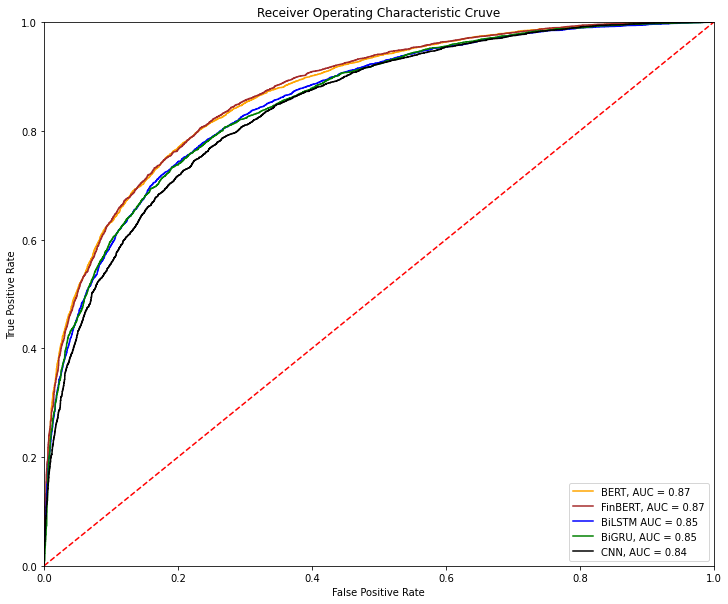

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
plt.figure(figsize=(12,10))

fpr_bert, tpr_bert, threshold = roc_curve(y_test, y_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'orange', label = 'BERT, AUC = %0.2f' % roc_auc_bert)

fpr_finbert, tpr_finbert, threshold = roc_curve(y_test, y_prob_finbert)
roc_auc_bert = auc(fpr_finbert, tpr_finbert)
plt.plot(fpr_finbert, tpr_finbert, 'brown', label = 'FinBERT, AUC = %0.2f' % roc_auc_bert)

fpr_lstm, tpr_lstm, threshold = roc_curve(np.asarray(eval(dp.iloc[3,8])), np.asarray(eval(dp.iloc[3,7])))
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, 'b', label = 'BiLSTM AUC = %0.2f' % roc_auc_lstm)

fpr_gru, tpr_gru, threshold = roc_curve(np.asarray(eval(dp.iloc[4,8])), np.asarray(eval(dp.iloc[4,7])))
roc_auc_gru = auc(fpr_gru, tpr_gru)
plt.plot(fpr_gru, tpr_gru, 'green', label = 'BiGRU, AUC = %0.2f' % roc_auc_gru)

fpr_cnn, tpr_cnn, threshold = roc_curve(np.asarray(eval(dp.iloc[5,8])), np.asarray(eval(dp.iloc[5,7])))
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, 'black', label = 'CNN, AUC = %0.2f' % roc_auc_cnn)

    # Plot ROC AUC
plt.title('Receiver Operating Characteristic Cruve')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef,accuracy_score,f1_score,precision_score,recall_score
def get_evaluation_metrics(y_true,y_pred):
    metrics_dict=dict()
    metrics_dict['accuracy']=accuracy_score(y_true,y_pred)
    metrics_dict['precision']=precision_score(y_true,y_pred)
    metrics_dict['recall']=recall_score(y_true,y_pred)
    metrics_dict['f1']=f1_score(y_true,y_pred)
    metrics_dict['matthews_corr']=matthews_corrcoef(y_true,y_pred)
    return metrics_dict

In [ ]:
y_pred=evaluate_roc(probs,y_test)
metrics=get_evaluation_metrics(y_test,y_pred)
print(metrics)

AUC: 0.8710
Accuracy: 78.38%
{'accuracy': 0.7837727864583334, 'precision': 0.7879107362502197, 'recall': 0.7556454330974048, 'f1': 0.7714408602150539, 'matthews_corr': 0.5668988061965222}
